In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, auc, confusion_matrix

%matplotlib inline

In [18]:
# check xgboost version
print(xgb.__version__)

1.7.0


In [5]:
%run 102-data_preprocessing.py

(16760, 104) (16760, 1)
(2394, 104) (2394, 1)


In [6]:
# load the model from disk
modelXGB = pickle.load(open(os.path.join(path_y_t1, 'xgbModel_best_v1.1.pkl'), 'rb'))

In [7]:
y_pred = modelXGB.predict(X_valid_t1)
# y_pred_proba = modelXGB.predict_proba(X_valid)[::,1]

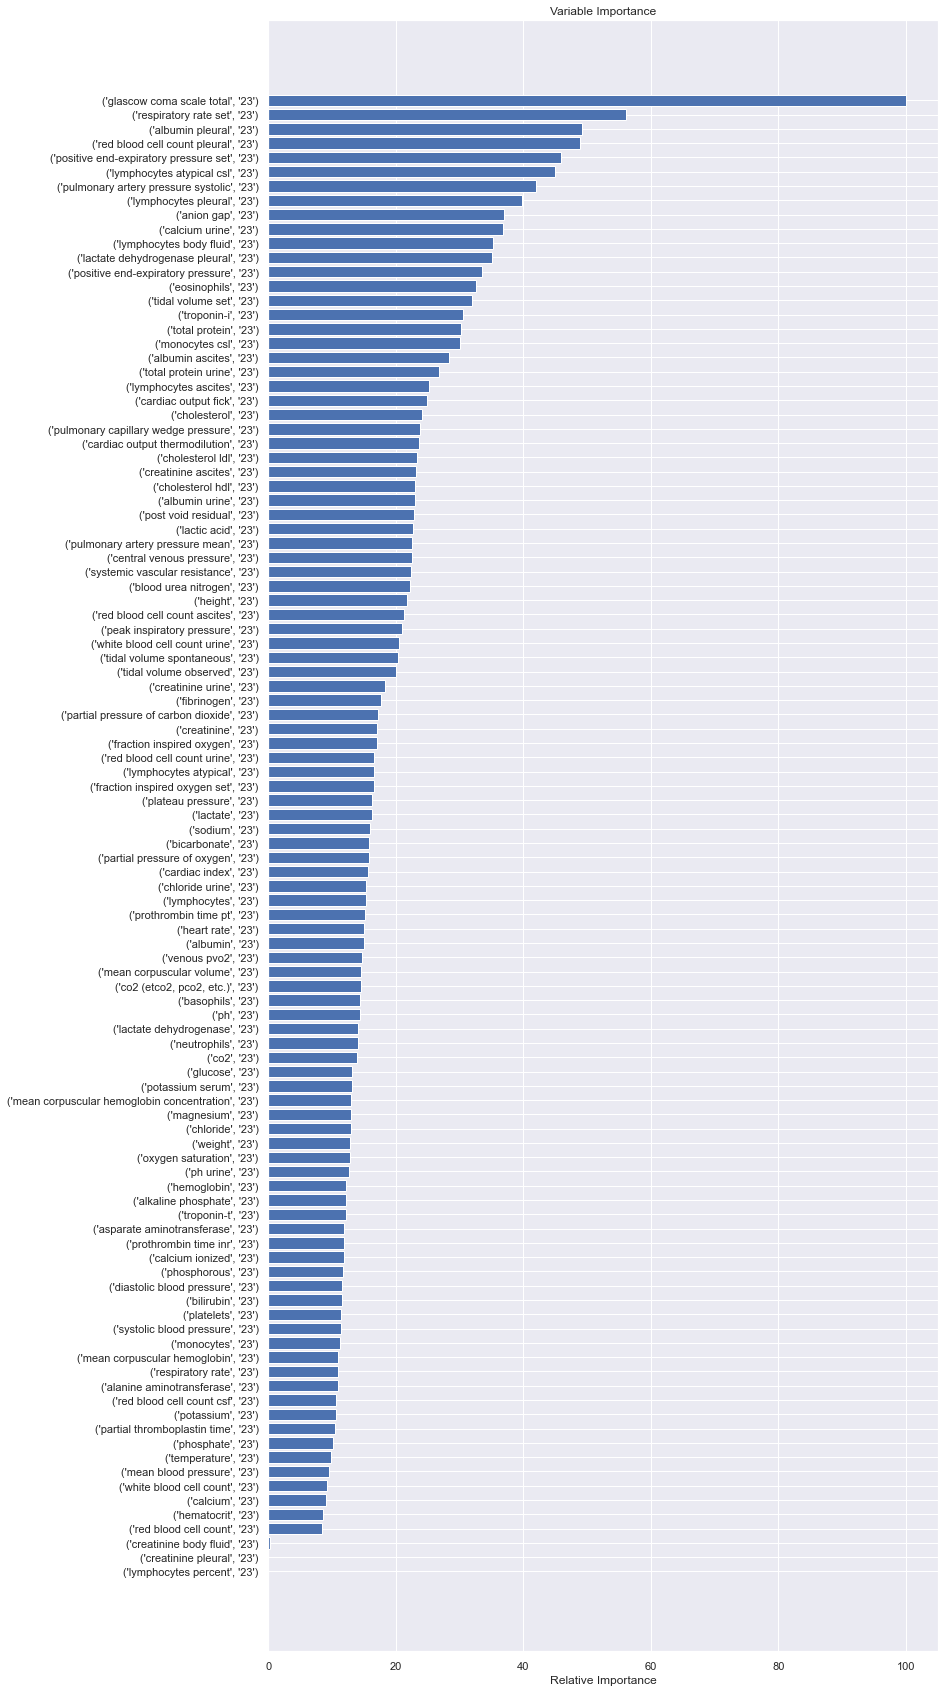

In [ ]:
# feature_names xgboost delete the string 23
feature_names = X_train_t1.columns
feature_importance = modelXGB.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 30))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

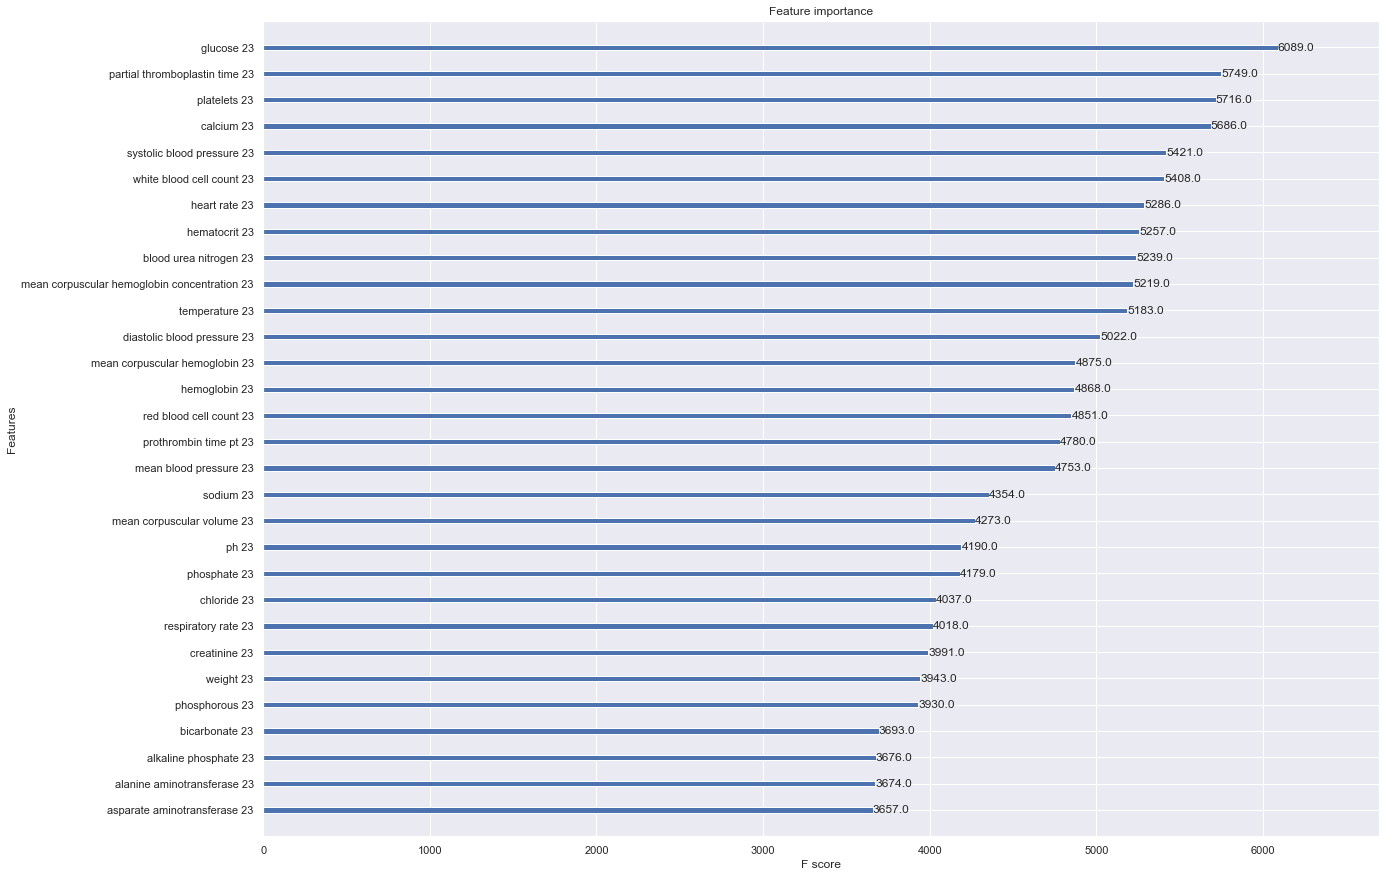

In [ ]:
### visualize the feature importance
sns.set(rc={'figure.figsize':(20, 15)})
xgb.plot_importance(modelXGB, max_num_features=30)
plt.savefig(os.path.join(path_y_t1, 'xgb_feature_importance.jpeg'), dpi=300, bbox_inches='tight')

In [12]:
# compute the y_pred score
y_pred_score = modelXGB.predict_proba(X_valid_t1)[:, 1]

In [ ]:
## plot the confusion matrix
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10, 7)})
cm = confusion_matrix(y_valid_t1, y_pred_score)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(path_y_t1, 'xgb_confusion_matrix.jpeg'), dpi=300, bbox_inches='tight')

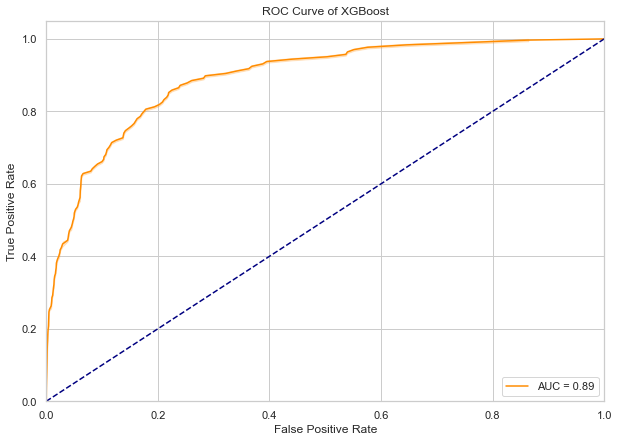

In [13]:
## plot the ROC curve
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
fpr, tpr, thresholds = roc_curve(y_valid_t1, y_pred_score)
roc_auc = auc(fpr, tpr)

sns.lineplot(x=fpr, y=tpr, label='AUC = %0.2f'% roc_auc, color='darkorange')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'--', color='navy')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.savefig(os.path.join(path_y_t1, 'xgb_roc_curve.jpeg'), dpi=300, bbox_inches='tight')

In [24]:
## pred the test data and save it
y_pred_test = modelXGB.predict_proba(X_test)[::,1]
y_pred_test = pd.DataFrame(y_pred_test, columns=['Predicted'])

X_test_1 = pd.read_csv(os.path.join(path_X, 'X_test.csv'), index_col=[0], header=[0,1,2])
y_pred_test.index = X_test_1.index # set the index
y_pred_test.reset_index(inplace=True) # reset the index
y_pred_test.rename({'index':'Id'}, axis=1, inplace=True) # rename the index column
y_pred_test.to_csv(os.path.join(path_y_t1, 'y_test-1.csv'), index=False)